In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

In [2]:
def ang(q1, q2):
    dot = sum(q1 * q2)
    q1len = np.sqrt(sum(q1 ** 2))
    q2len = np.sqrt(sum(q2 ** 2))
    return np.arccos(dot / (q1len * q2len))

def slerp(q1, q2, t):
    o = ang(q1, q2)
    return np.sin(o * (1 - t)) / np.sin(o) * q1 + np.sin(o * t)/np.sin(o) * q2

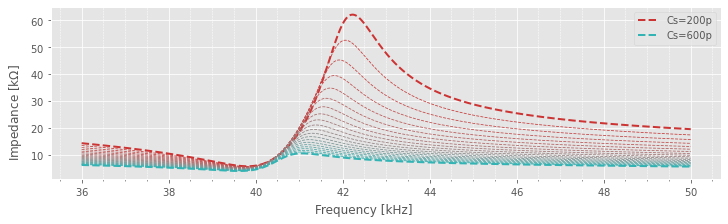

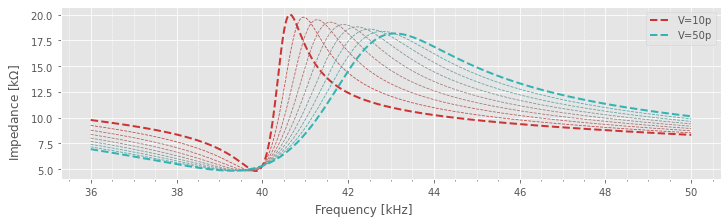

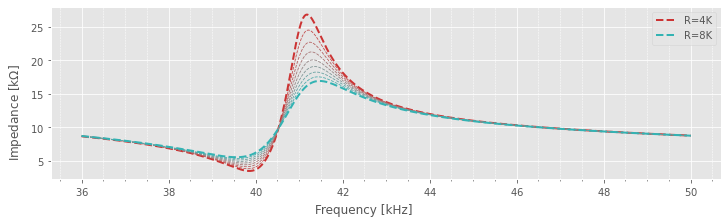

In [3]:
inpath = Path("data")

for p in inpath.glob("*.txt"):
    outpath = Path("plots", p.stem + ".pdf")

    with open(p, "r", encoding="latin1") as fd:
        lines = fd.read().strip().split("\n")[1:]
    lines = np.array(lines)
    rawdata = np.split(lines, np.where(["Step" in x for x in lines])[0])[1:]

    sweeps = {}
    for dat in rawdata:
        cs = dat[0].split(": ")[1].split(" ")[0]
        data = {"freq": [], "amp": []}
        for d in dat[1:]:
            freq, x = d.split("\t")
            amp, phase = x[1:-2].split(",")

            freq = float(freq)
            amp = float(amp[:-2])

            data["freq"].append(freq)
            data["amp"].append(amp)
        sweeps[cs] = data

    fig, ax = plt.subplots(1, 1)

    c1 = np.array([0.8, 0.2, 0.2])
    c2 = np.array([0.2, 0.7, 0.7])
    for i, (k, v) in enumerate(sweeps.items()):
        t = i / (len(sweeps) - 1)
        color = slerp(c1, c2, t)
        # color = t * c2 + (1 - t) * c1

        if i == 0 or i == len(sweeps) - 1:
            ax.plot([x/1000 for x in v["freq"]], [10**(x/20)/1000 for x in v["amp"]], "--", c=color, label=k, lw=2)
        else:
            ax.plot([x/1000 for x in v["freq"]], [10**(x/20)/1000 for x in v["amp"]], "--", c=color)

    ax.legend()
    ax.grid(True, "minor", lw=0.5, ls="--")
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    fig.supxlabel("Frequency [kHz]")
    fig.supylabel(r"Impedance [k$\Omega$]")
    
    fig.savefig(outpath)

# Custom sweeps

In [4]:
def freq_resp(R_s, C_s, C_p, w):
    L_s=1 / ((2*np.pi*40e3)**2 * C_s)
    return np.sqrt(
        ( R_s**2 + (w*L_s - w**-1 * C_s**-1)**2 ) /
        ( (C_p * (C_s**-1 - w**2 * L_s) + 1)**2 + w**2 * C_p**2 * R_s**2 )
    )

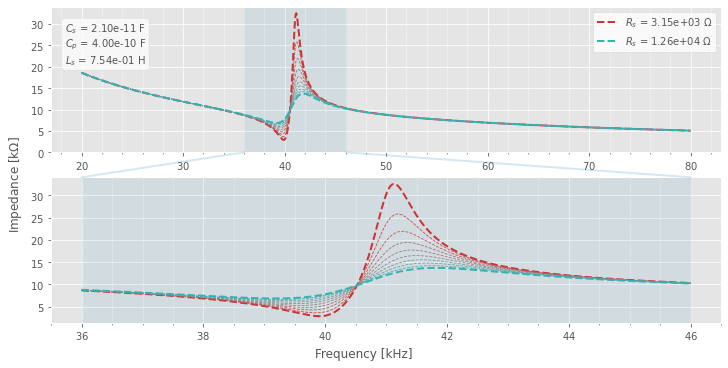

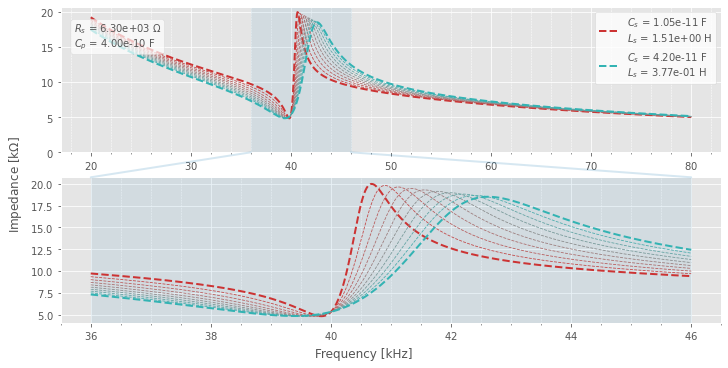

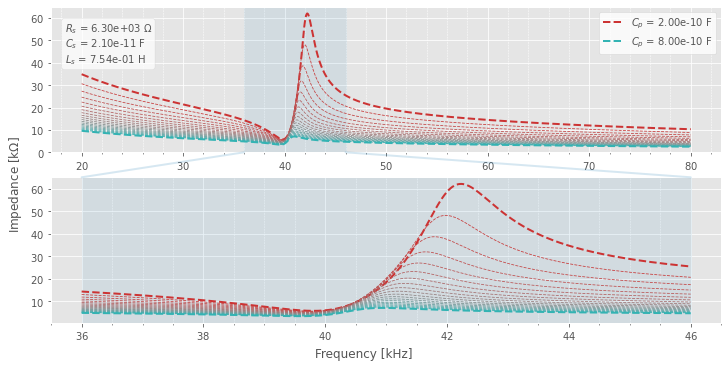

In [9]:
default_values = dict(
    R_s=6.3e3,
    C_s=21e-12,
    C_p=400e-12
)
units = dict(R_s=r"$\Omega$", C_s="F", C_p="F", L_s="H")
sweep_cases = [
    ["R_s", [4e3,     8e3,     10]],
    ["C_s", [10e-12,  50e-12,  10]],
    ["C_p", [200e-12, 600e-12, 20]],
]

c1 = np.array([0.8, 0.2, 0.2])
c2 = np.array([0.2, 0.7, 0.7])
for par, ran in sweep_cases:
    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10,5))
    
    ran = [0.5*default_values[par], 2*default_values[par], ran[2]]
    for val in np.linspace(*ran):
        t = (val - ran[0]) / (ran[1] - ran[0])
        col = slerp(c1, c2, t)
        
        vals = default_values.copy()
        vals[par] = val
        
        f = np.linspace(20e3, 80e3, 1000)
        w = f * 2*np.pi
        
        f2 = np.linspace(36e3, 46e3, 1000)
        w2 = f2 * 2*np.pi
        
        H = freq_resp(**vals, w=w)
        H2 = freq_resp(**vals, w=w2)
        
        label = fr"${par}$ = {val:.2e} "+units[par]
        if par == "C_s":
            L_s = 1 / ((2*np.pi*40e3)**2 * val)
            label += f"\n$L_s$ = {L_s:.2e} "+units["L_s"]
        
        if t in [0, 1]:
            ax.plot(f/1000, H/1000, c=col, ls="--", lw=2, label=label)
            ax2.plot(f2/1000, H2/1000, c=col, ls="--", lw=2)
        else:
            ax.plot(f/1000, H/1000, c=col, ls="--")
            ax2.plot(f2/1000, H2/1000, c=col, ls="--")
    
    if par != "C_s":
        vals["L_s"] = 1 / ((2*np.pi*40e3)**2 * vals["C_s"])
    vals.pop(par)
    defvals = "\n".join(f"${k}$ = {v:.2e} "+units[k] for k, v in vals.items())
    
    ax.annotate(defvals, (0.02,0.9), xycoords="axes fraction", ha="left", va="top",
               bbox=dict(boxstyle="round", fc="#fff", ec="lightgray", alpha=0.7))
    
    t1 = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    t2 = mpl.transforms.blended_transform_factory(ax2.transData, ax2.transAxes)
    for x in [36, 46]:
        con = mpl.patches.ConnectionPatch(
            xyA=(x,0), xyB=(x,1),
            coordsA=t1, coordsB=t2,
            lw=2, color="C1", alpha=0.2)
        fig.add_artist(con)
    ax .axvspan(36, 46, color="C1", alpha=0.1)
    ax2.axvspan(36, 46, color="C1", alpha=0.1)
    
    ax.legend(facecolor="#fff")
    ax.set_ylim(ymin=0)
    ax.grid(True, "minor", ls="--", lw=0.5)
    ax2.grid(True, "minor", ls="--", lw=0.5)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
    ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    fig.supxlabel("Frequency [kHz]")
    fig.supylabel("Impedance [k$\Omega$]")
    
    outpath = Path("plots", f"sweep_{par}.pdf")
    outpath.parent.mkdir(exist_ok=True,parents=True)
    fig.savefig(outpath)

# Final values plot

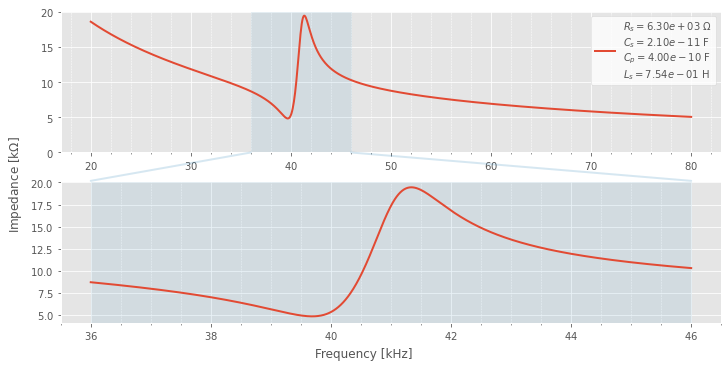

In [8]:
default_values = dict(
    R_s=6.3e3,
    C_s=21e-12,
    C_p=400e-12
)
units = dict(R_s=r"$\Omega$", C_s="F", C_p="F", L_s="H")

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10,5))

f = np.linspace(20e3, 80e3, 1000)
w = f * 2*np.pi
H = freq_resp(**default_values, w=w)

f2 = np.linspace(36e3, 46e3, 1000)
w2 = f2 * 2*np.pi
H2 = freq_resp(**default_values, w=w2)

vals = default_values.copy()
vals["L_s"] = 1 / ((2*np.pi*40e3)**2 * vals["C_s"])

ax.plot(f/1000, H/1000, lw=2, label="\n".join(f"${k} = {v:.2e}$ "+units[k] for k, v in vals.items()))
ax2.plot(f2/1000, H2/1000, lw=2)

t1 = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
t2 = mpl.transforms.blended_transform_factory(ax2.transData, ax2.transAxes)
for x in [36, 46]:
    con = mpl.patches.ConnectionPatch(
        xyA=(x,0), xyB=(x,1),
        coordsA=t1, coordsB=t2,
        lw=2, color="C1", alpha=0.2)
    fig.add_artist(con)
ax .axvspan(36, 46, color="C1", alpha=0.1)
ax2.axvspan(36, 46, color="C1", alpha=0.1)
        
ax.legend(facecolor="#fff")
ax.set_ylim(ymin=0)
ax.grid(True, "minor", ls="--", lw=0.5)
ax2.grid(True, "minor", ls="--", lw=0.5)
ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
fig.supxlabel("Frequency [kHz]")
fig.supylabel("Impedance [k$\Omega$]")

outpath = Path("plots", f"final.pdf")
outpath.parent.mkdir(exist_ok=True,parents=True)
fig.savefig(outpath)